
### Covariance Matrix

**Covariance** measures how two variables move together:
- Positive: Variables increase together
- Negative: One increases, other decreases  
- Zero: Variables are uncorrelated

For **p** assets, the covariance matrix **Σ** is **p × p** where:
- Diagonal: Variances of individual assets
- Off-diagonal: Covariances between asset pairs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from estimators import Estimators
from dataset_generator import generate_synthetic_returns
from evaluation import compute_condition_number, compute_frobenius_error, benchmark_estimators

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


In [2]:
## Synthetic Dataset with Cholesky Decomposition

n_stocks = 100  
n_days = 252    

print(f"Generating synthetic data for {n_stocks} stocks and {n_days} days")

X, true_cov, metadata = generate_synthetic_returns(
    n_stocks=n_stocks,
    n_days=n_days,
    random_seed=42
)

Generating synthetic data for 100 stocks and 252 days


In [3]:
X.shape
#day return_stock1, return_stock2, ...
#day1 [0.1, 0.2, 0.3]
#day2 [0.4, 0.5, 0.6]

(252, 100)

### Visualize the Data

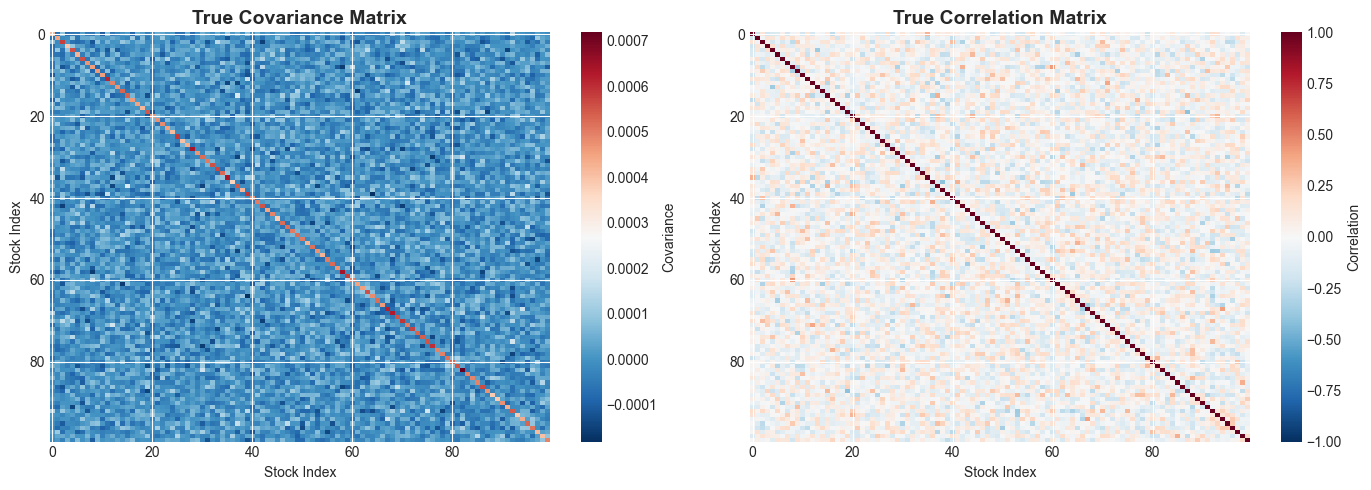

In [4]:
# Visualize true covariance and correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True covariance heatmap
im1 = axes[0].imshow(true_cov, cmap='RdBu_r', aspect='auto')
axes[0].set_title('True Covariance Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stock Index')
axes[0].set_ylabel('Stock Index')
plt.colorbar(im1, ax=axes[0], label='Covariance')

# True correlation heatmap
true_corr = np.corrcoef(X.T)
im2 = axes[1].imshow(true_corr, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1].set_title('True Correlation Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stock Index')
axes[1].set_ylabel('Stock Index')
plt.colorbar(im2, ax=axes[1], label='Correlation')

plt.tight_layout()
plt.show()

#This is what we're trying the estimators to estimate
#we know this information because we generated the data
#estimator will try to estimate this matrix from the data

In [5]:
#Each estimator will recieve the returns matrix X and will try to estimate the covariance matrix
#then condition number and frobenius error, will be computed to see how similar the estimated matrix is to the true matrix

est = Estimators()


print("Running estimators...\n")
results = benchmark_estimators(X, true_cov, est)


Running estimators...



In [6]:
#Benchmarks
print(results.to_string(index=False))

     estimator_name  condition_number  frobenius_error  relative_error  computation_time
  Sample Covariance     404216.970483         0.003281        0.461878          0.000297
        Ledoit-Wolf         14.062096         0.002726        0.383749          0.007637
          Tyler's M     414599.794011         0.003591        0.505551          0.115096
Tyler's + Shrinkage          1.024492         0.999877      140.752965          0.106038
              T-REX         12.513397         0.002738        0.385482          0.008361


**Best Condition Number:** Tyler's + Shrinkage

**Lowest Frobenius Error (Accuracy):** Ledoit-Wolf

**Fastest Computation:** Sample Covariance

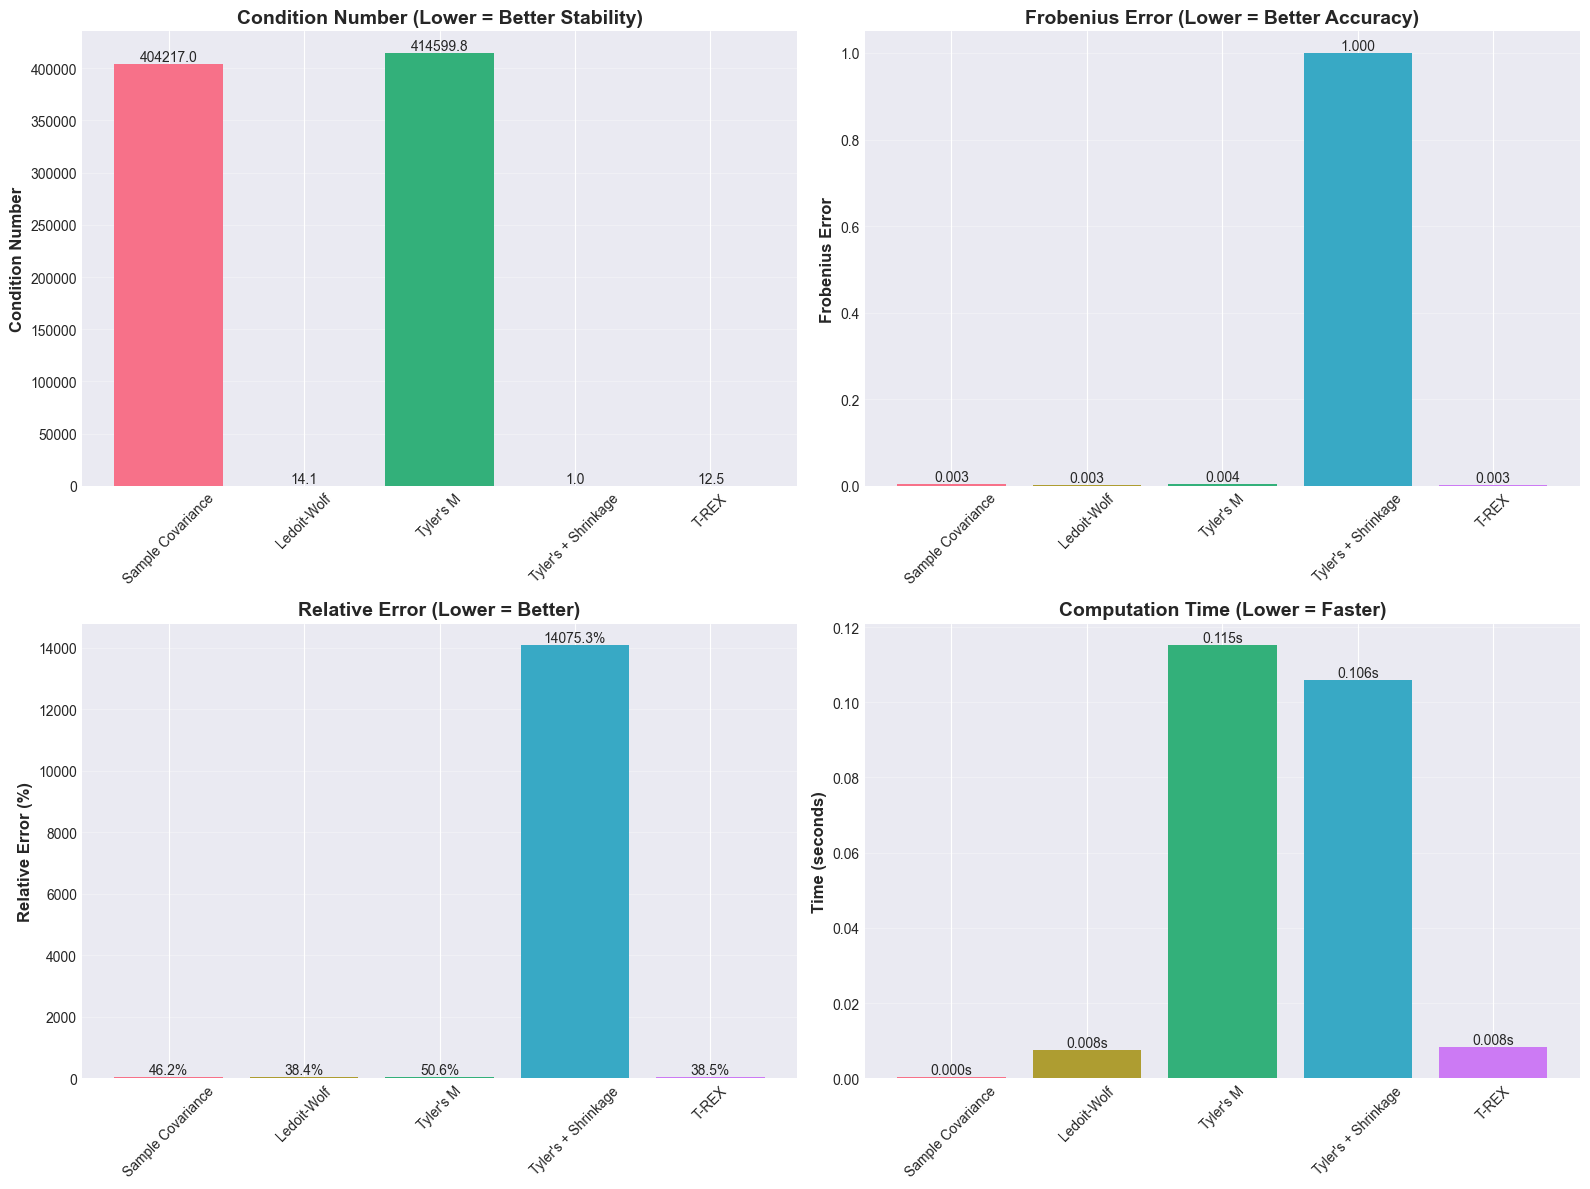

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Condition Number
ax1 = axes[0, 0]
bars1 = ax1.bar(results['estimator_name'], results['condition_number'], 
                color=sns.color_palette("husl", len(results)))
ax1.set_ylabel('Condition Number', fontsize=12, fontweight='bold')
ax1.set_title('Condition Number (Lower = Better Stability)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 2. Frobenius Error
ax2 = axes[0, 1]
bars2 = ax2.bar(results['estimator_name'], results['frobenius_error'],
                color=sns.color_palette("husl", len(results)))
ax2.set_ylabel('Frobenius Error', fontsize=12, fontweight='bold')
ax2.set_title('Frobenius Error (Lower = Better Accuracy)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Relative Error
ax3 = axes[1, 0]
bars3 = ax3.bar(results['estimator_name'], results['relative_error'] * 100,
                color=sns.color_palette("husl", len(results)))
ax3.set_ylabel('Relative Error (%)', fontsize=12, fontweight='bold')
ax3.set_title('Relative Error (Lower = Better)', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# 4. Computation Time
ax4 = axes[1, 1]
bars4 = ax4.bar(results['estimator_name'], results['computation_time'],
                color=sns.color_palette("husl", len(results)))
ax4.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Computation Time (Lower = Faster)', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


**Condition Number** (numerical stability):
- Related to numerical stability. The lower value the better
- Stability reffers to how small errors cause huge changes in portfolio weights

**Frobenius Error** (estimation accuracy):
- Distance between estimated and true covariance
- Lower = closer to truth

**Relative Error** (normalized accuracy):
- Frobenius error as % of true covariance norm
- Easier to interpret across scales

## **Interpretations**

#### Ledoit-Wolf

- Excellent condition number (stable, doesnt get extremely affected by small estimation errors)
- **Best Frobenius error** (most accurate)
- Fast computation
- Uses a formula that calculates the shrinkage intensity (δ) that minimizes the expected squared error between the estimate and true covariance, by pulling covariance to an indetity matrix, reducing  bias
- Use for the best accuracy with good stability, for risk measurement, correlation analysis

#### Tyler's M

- Poor condition number (~400,000), Low Frobenius error, Slowest (iterative algorithm)
- Focuses on correlation patterns, ignores magnitude, so outliers don't dominate
- Protects against extreme events (market crashes, anomalies)
- Helpful for inancial crises, market disruptions

#### Tyler's + Shrinkage

- **Best condition number** (most stable), high Frobenius error (least accurate), Slow computation
- Applies TWO layers of protection:
  1. Tyler's M: Protects against outliers
  2. Shrinkage: Pulls everything toward a safe middle ground (identity matrix)
- Being so cautious means losing information, therefore the estimate is far from the true covariance

#### T-REX

- Excellent condition number (~13), Good Frobenius error, Fast computation

- Decides many correlations are just noise and sets them to zero
- Removes weak/noisy correlations that hurt stability, and keeps strong correlations that matter

- Very high dimensions (p >> n), so could be use with long training timeframes
- Useful to see clear correlation patterns

Tyler's + Shrinkage is safer, because is more stable,  but Ledoit-Wolf is more accruate and keeps stability

- For low-risk portfolios Tyler's + Shrinkage might be better. Also good when you have few data and therefore you can't trust it. Slow Calculations

- For relationship analysis Ledoit-Wolf is better.Fast.

-T-Rex gets rid of all not important correlations and can be more interpretable